Aquí están todos los imports de las librías que usaremos


In [3]:
import os
import sys
import time
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import ShuffleSplit
from tensorflow import keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

Aquí hacemos la lectura del dataset "FASHION-MNIST"


In [4]:
test = np.loadtxt("archive/fashion-mnist_test.csv", delimiter=',', skiprows=1)
train = np.loadtxt("archive/fashion-mnist_train.csv",
                   delimiter=',', skiprows=1)

test = test[1:]
train = train[1:]

data = np.vstack((train, test))

X = data[:, 1:]
y = data[:, 0]

X = np.array(X)
y = np.array(y, dtype=np.uint8)


print(X.shape, y.shape)


(69998, 784) (69998,)


Ahora mostraremos unos ejemplos del dataset para ver como es:


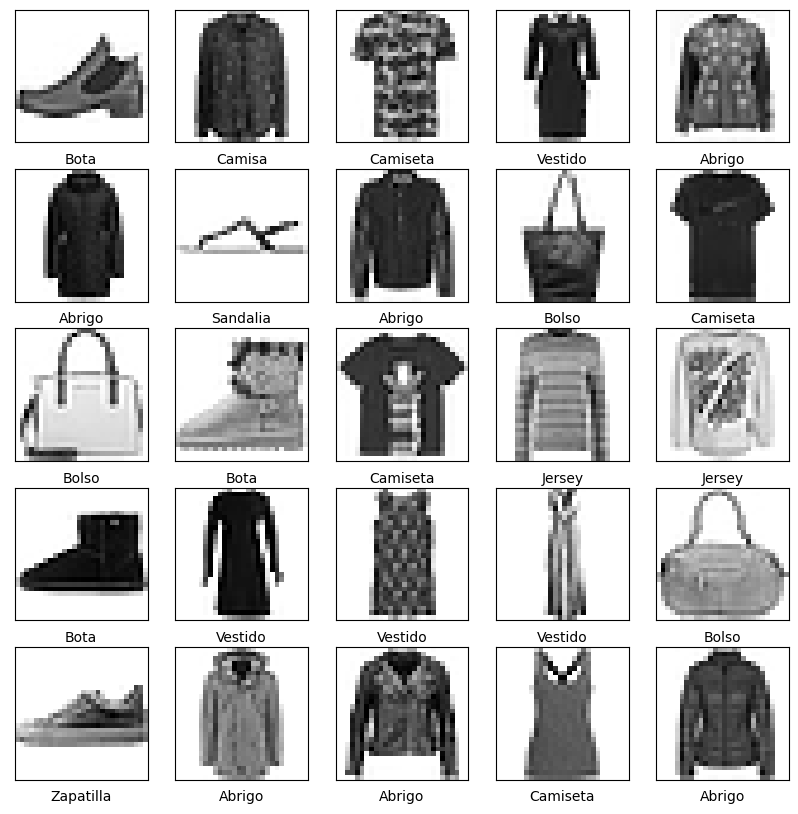

In [5]:
clases = ['Camiseta', 'Pantalon', 'Jersey', 'Vestido', 'Abrigo',
          'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota']
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(clases[int(y[i])])
plt.show()


Ahora haremos el particionamiento de datos usando shuffle split para así asegurarnos de que todos los ejemplos no estén condicionados entre sí.


In [6]:

rs = ShuffleSplit(n_splits=10, test_size=.20, random_state=0)
for train_index, test_index in rs.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]


print("SHAPE Xtrain", X_train.shape)
print("SHAPE y_train", y_train.shape)
print("SHAPE X_test", X_test.shape)
print("SHAPE y_test", y_test.shape)


SHAPE Xtrain (55998, 784)
SHAPE y_train (55998,)
SHAPE X_test (14000, 784)
SHAPE y_test (14000,)


Como primer clasificador usaremos un SVM. Lo primero que haremos será optimizar los parámteros mediante gridSearch para así obtener unos resultados óptimos.


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

num_elements = 4000
indices = np.random.choice(len(X), size=num_elements, replace=False)
X_subset = X[indices]
Y_subset = y[indices]

startTimer = time.perf_counter()

C_values = [0.1, 1.0, 5.0, 7.5, 10.0]
gamma_values = [0.001, 0.01, 0.1, 1, 10]

# Genera el diccionario param_grid con los valores indicados
param_grid = {'C': C_values, 'gamma': gamma_values}

# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y
# random_state = 0
rs = ShuffleSplit(n_splits=1, test_size=.20, random_state=0)

# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
clasificadores = GridSearchCV(svm.SVC(), param_grid, n_jobs=-1, cv=rs)

# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores.fit(X_subset, Y_subset)

C_best = clasificadores.best_params_["C"]
gamma_best = clasificadores.best_params_["gamma"]

print("Mejores parámetros C: {}, gamma: {}".format(C_best, gamma_best))

# Crea y entrena un modelo SVC con C_best y gamma_best sobre los datos de train originales (X e y)
clf = svm.SVC(C=C_best, gamma=gamma_best)
clf.fit(X_train, y_train)

# Realizamos predicciones con el clasificador entrenado
y_pred = clf.predict(X_test)

# Calculamos el porcentaje de acierto
accuracy = np.mean(y_pred == y_test)
print("Precisión: {:.2f}%".format(accuracy * 100))

# Detenemos el contador de tiempo
endTimer = time.perf_counter()

# Calculamos el tiempo transcurrido
elapsed = endTimer - startTimer
# Obtenemos el tiempo transcurrido en minutos y segundos
minutes, seconds = divmod(elapsed, 60)

# Mostramos el tiempo transcurrido en minutos y segundos
print(f"Tiempo transcurrido: {minutes:.0f} minutos {seconds:.2f} segundos")

Mejores parámetros C: 0.1, gamma: 0.001
Precisión: 9.44%
Tiempo transcurrido: 68 minutos 20.79 segundos


In [24]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))


Accuracy: 0.8892142857142857


              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1390
           1       1.00      0.97      0.99      1365
           2       0.81      0.82      0.81      1407
           3       0.87      0.91      0.89      1380
           4       0.82      0.85      0.83      1477
           5       0.96      0.96      0.96      1467
           6       0.75      0.65      0.69      1425
           7       0.93      0.95      0.94      1322
           8       0.98      0.97      0.98      1392
           9       0.97      0.96      0.96      1375

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



In [26]:
clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))


Ahora usaremos una MLP como clasificador. Para agilizar las ejecuciones vamos a usar tensorFlow y scikeras para que la ejecucion se haga en la GPU 

Aquí definimos el modelo (el clasificador): el parámetro "hidden_layer_sizes" es una tupla que indica el numero de neuronas en la capa i-esima; el diccionario "meta" tiene varios atributos: "target_type_" indica el tipo de porblemas que nos encontramos, en este caso sería multiclase con "n_classes_" clases; por último el parámetro compilacion es un diccionario que tiene los parametros relacionados a la compilacion, como por ejemplo "optimizer" que indica el tipo de optimizador que usaremos.

In [7]:
def get_clf_model(meta, compilacion, hidden_layer_sizes = (20,) ):
    model = keras.Sequential()
    inp = keras.layers.Input(shape=(meta["n_atributos"]))
    model.add(inp)
    for hidden_layer_size in hidden_layer_sizes:
        layer = keras.layers.Dense(hidden_layer_size, activation="relu")
        model.add(layer)
    if meta["target_type_"] == "binary":
        n_output_units = 1
        output_activation = "sigmoid"
        loss = "binary_crossentropy"
    elif meta["target_type_"] == "multiclass":
        n_output_units = meta["n_classes_"]
        output_activation = "softmax"
        loss = "sparse_categorical_crossentropy"
    else:
        raise NotImplementedError(f"Unsupported task type: {meta['target_type_']}")
    out = keras.layers.Dense(n_output_units, activation=output_activation)
    model.add(out)
    model.compile(loss=loss, optimizer=compilacion["optimizer"])
    return model

Aqui definimos los parametros del modelo:


In [8]:
meta = {"target_type_": "multiclass", "n_classes_": 10, "n_atributos": X_train.shape[1]}
compilacion = {"optimizer":"adam"}
hidden_layer_sizes = (100, 60, 20)
alpha = 0.01

Creamos el clasificador:

In [9]:
clf = KerasClassifier(
    model=get_clf_model(meta = meta, compilacion = compilacion, hidden_layer_sizes = (100, 60, 20)),
    optimizer__learning_rate = alpha,
    verbose=0, epochs= 200
)
print(clf.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 60)                6060      
                                                                 
 dense_2 (Dense)             (None, 20)                1220      
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 85,990
Trainable params: 85,990
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
clf.fit(X_train, y_train)

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x0000026A58DF0CD0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	optimizer__learning_rate=0.01
	class_weight=None
)

In [11]:
print(clf.score(X_test, y_test))

0.8732142857142857


In [13]:
hidden_sizes = range(60, 150, 10)
hidden_sizes2 = range(30, 90, 10)
accuracies = np.zeros((len(hidden_sizes),len(hidden_sizes2)))

best =  np.zeros(2)
best_acc = 0
pbar = tqdm(total=len(hidden_sizes)*len(hidden_sizes2))


for i, size in enumerate(hidden_sizes):
    for j, size2 in enumerate(hidden_sizes2):

        clasificador = KerasClassifier(
        model=get_clf_model(meta = meta, compilacion = compilacion, hidden_layer_sizes = (size,size2,)),
        optimizer__learning_rate = alpha, verbose=0, batch_size= 3000, epochs= 200)
        
        clasificador.fit(X_train,y_train.ravel())
        
        y_pred = clasificador.predict(X_test)
        
        accuracy = accuracy_score(y_pred, y_test)
        if accuracy > best_acc:
            best_acc = accuracy
            best[0] = size
            best[1] = size2
            
        accuracies[i,j] = accuracy
        pbar.update(1)
pbar.close()
accuracies = accuracies.flatten()
print('Max accuracy con:', best)
print(max(accuracies))
# Muestra en una gráfica como ha cambiado el error conforme aumentábamos hidden_sizes


  0%|          | 0/54 [00:00<?, ?it/s]

[80 30]
['60,30', '70,30', '80,30', '90,30', '100,30', '110,30', '120,30', '130,30', '140,30', '60,40', '70,40', '80,40', '90,40', '100,40', '110,40', '120,40', '130,40', '140,40', '60,50', '70,50', '80,50', '90,50', '100,50', '110,50', '120,50', '130,50', '140,50', '60,60', '70,60', '80,60', '90,60', '100,60', '110,60', '120,60', '130,60', '140,60', '60,70', '70,70', '80,70', '90,70', '100,70', '110,70', '120,70', '130,70', '140,70', '60,80', '70,80', '80,80', '90,80', '100,80', '110,80', '120,80', '130,80', '140,80']
[140.  70.]


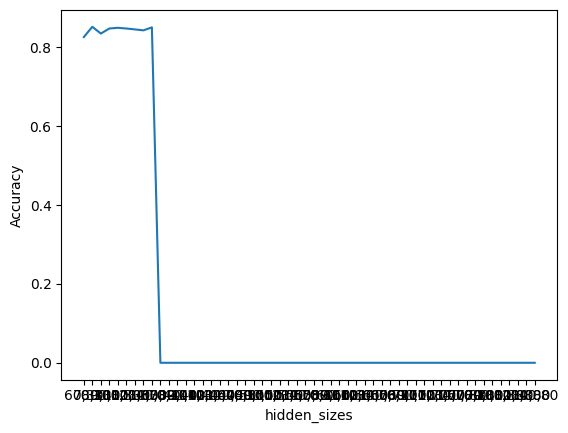

In [ ]:
import numpy as np

x = hidden_sizes
y = hidden_sizes2

X, Y = np.meshgrid(x, y)

combinations = np.stack((X.flatten(), Y.flatten())).T

indices = []

for i in range(len(combinations)):
    indices.append(','.join(map(str, combinations[i]))) 
plt.plot(indices, accuracies)
plt.xlabel('hidden_sizes');
plt.ylabel('Accuracy');
print(best)

In [110]:
print(accuracies)

[0.82642857 0.8525     0.83528571 0.84814286 0.84992857 0.84807143
 0.84585714 0.84342857 0.851      0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


Ahora intenaremos optimizar los parámetros del MLP mediante gridSearch

In [44]:
class MLPClassifier(KerasClassifier):

    def __init__(
        self,
        hidden_layer_sizes=(100, ),
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=200,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = keras.Sequential()
        inp = keras.layers.Input(shape=(self.n_features_in_))
        model.add(inp)
        for hidden_layer_size in self.hidden_layer_sizes:
            layer = keras.layers.Dense(hidden_layer_size, activation="relu")
            model.add(layer)
        if self.target_type_ == "binary":
            n_output_units = 1
            output_activation = "sigmoid"
            loss = "binary_crossentropy"
        elif self.target_type_ == "multiclass":
            n_output_units = self.n_classes_
            output_activation = "softmax"
            loss = "sparse_categorical_crossentropy"
        else:
            raise NotImplementedError(f"Unsupported task type: {self.target_type_}")
        out = keras.layers.Dense(n_output_units, activation=output_activation)
        model.add(out)
        model.compile(loss=loss, optimizer=compile_kwargs["optimizer"])
        return model

In [ ]:
param_grid = {'hidden_layer_sizes': [(10,), (50,), (100,)], 'alpha': [0.01, 0.1, 1.0],' learning_rate_init': [0.001, 0.01, 0.1]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

In [13]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV


def create_model(C=1.0, gamma=1.0):
    model = tf.keras.Sequential()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


model = KerasClassifier(model=create_model)

# define the parameter values that should be searched
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
gamma_values = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 1.0]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'C': c_values, 'gamma': gamma_values}

# instantiate the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

# fit the grid with data
grid.fit(X_train, y_train)

# view the results
print(grid.best_params_)
print(grid.best_score_)


AttributeError: module 'keras.api._v2.keras.estimator' has no attribute 'SVC'